# Ames battery prognosis

Based on article [A Data-Driven Predictive Prognostic Model for Lithium-ion Batteries based on a Deep Learning Algorithm](https://www.mdpi.com/1996-1073/12/4/660).

Dataset available at [NASA Prognostics Center of Excellence](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/).

## Environment setup

In [9]:
import os
import zipfile
import csv
from collections import Counter
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [10]:
# Setup plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [11]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.20"

from sklearn.preprocessing import StandardScaler

scikit-learn version: 0.22.2.post1


## Dataset download and extraction

In [12]:
download_path = "/tmp/"

# Download dataset as ZIP archive on local storage
!wget --no-check-certificate https://ti.arc.nasa.gov/c/5/ -O "/tmp/nasa_ames_battery.zip"

--2020-09-23 16:35:47--  https://ti.arc.nasa.gov/c/5/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/BatteryAgingARC-FY08Q4.zip [following]
--2020-09-23 16:35:47--  https://ti.arc.nasa.gov/m/project/prognostic-repository/BatteryAgingARC-FY08Q4.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 56517371 (54M) [application/zip]
Saving to: ‘/tmp/nasa_ames_battery.zip’

/tmp/nasa_ames_batt 100%[===================>]  53.90M  36.3MB/s    in 1.5s    

2020-09-23 16:35:49 (36.3 MB/s) - ‘/tmp/nasa_ames_battery.zip’ saved [56517371/56517371]



In [13]:
# Extract ZIP archive
zip_ref = zipfile.ZipFile(archive_file_path, 'r')
zip_ref.extractall(download_path)
zip_ref.close()

## Data plotting for a battery

In [14]:
def get_file_data(mat_file_name):
    """Load a MATLAB file and return its data"""

    mat_file_path = download_path + mat_file_name + ".mat"
    mat_file = scipy.io.loadmat(mat_file_path)
    print(f"File '{mat_file_path}' loaded")

    # Parse file data
    mat_data = mat_file[mat_file_name]
    return mat_data

In [15]:
# Define plotted battery number
battery_number = 5

mat_file_name = "B00" + f"{battery_number:02d}"
mat_data = get_file_data(mat_file_name)

cycles = mat_data[0][0][0][0]
cycle_count = len(cycles)
print(f"{cycle_count} cycles found")

File '/tmp/B0005.mat' loaded
616 cycles found


In [16]:
# Parse battery cycles

cycle_types = []
battery_soh = []
charging_voltages = []
discharging_voltages = []
charging_currents = []
discharging_currents = []
initial_capacity = None

for i, cycle in enumerate(cycles):
    # Cycle structure: type, ambient_temperature, time, data
    cycle_type = cycle[0][0]
    cycle_types.append(cycle_type)
    # print(f"Cycle {i+1}: {cycle_type}")
    cycle_data = cycle[3]

    if cycle_type == "charge" and i == 0:
        # Charge cycle structure: Voltage_measured, Current_measured, Temperature_measured,	Current_charge, Voltage_charge, Time
        charging_voltages = cycle_data[0][0][0][0]
        charging_currents = cycle_data[0][0][1][0]

    elif cycle_type == "discharge":
        # Discharge cycle structure: Voltage_measured, Current_measured, Temperature_measured,	Current_charge, Voltage_charge, Time, Capacity
        cycle_capacity = cycle_data[0][0][6][0][0]
        if initial_capacity == None:
            # First discharging cycle
            initial_capacity = cycle_capacity
            discharging_voltages = cycle_data[0][0][0][0]
            discharging_currents = cycle_data[0][0][1][0]
        battery_soh.append(cycle_capacity / initial_capacity)

print("Cycle types " + str(dict(Counter(cycle_types))))

Cycle types {'charge': 170, 'discharge': 168, 'impedance': 278}


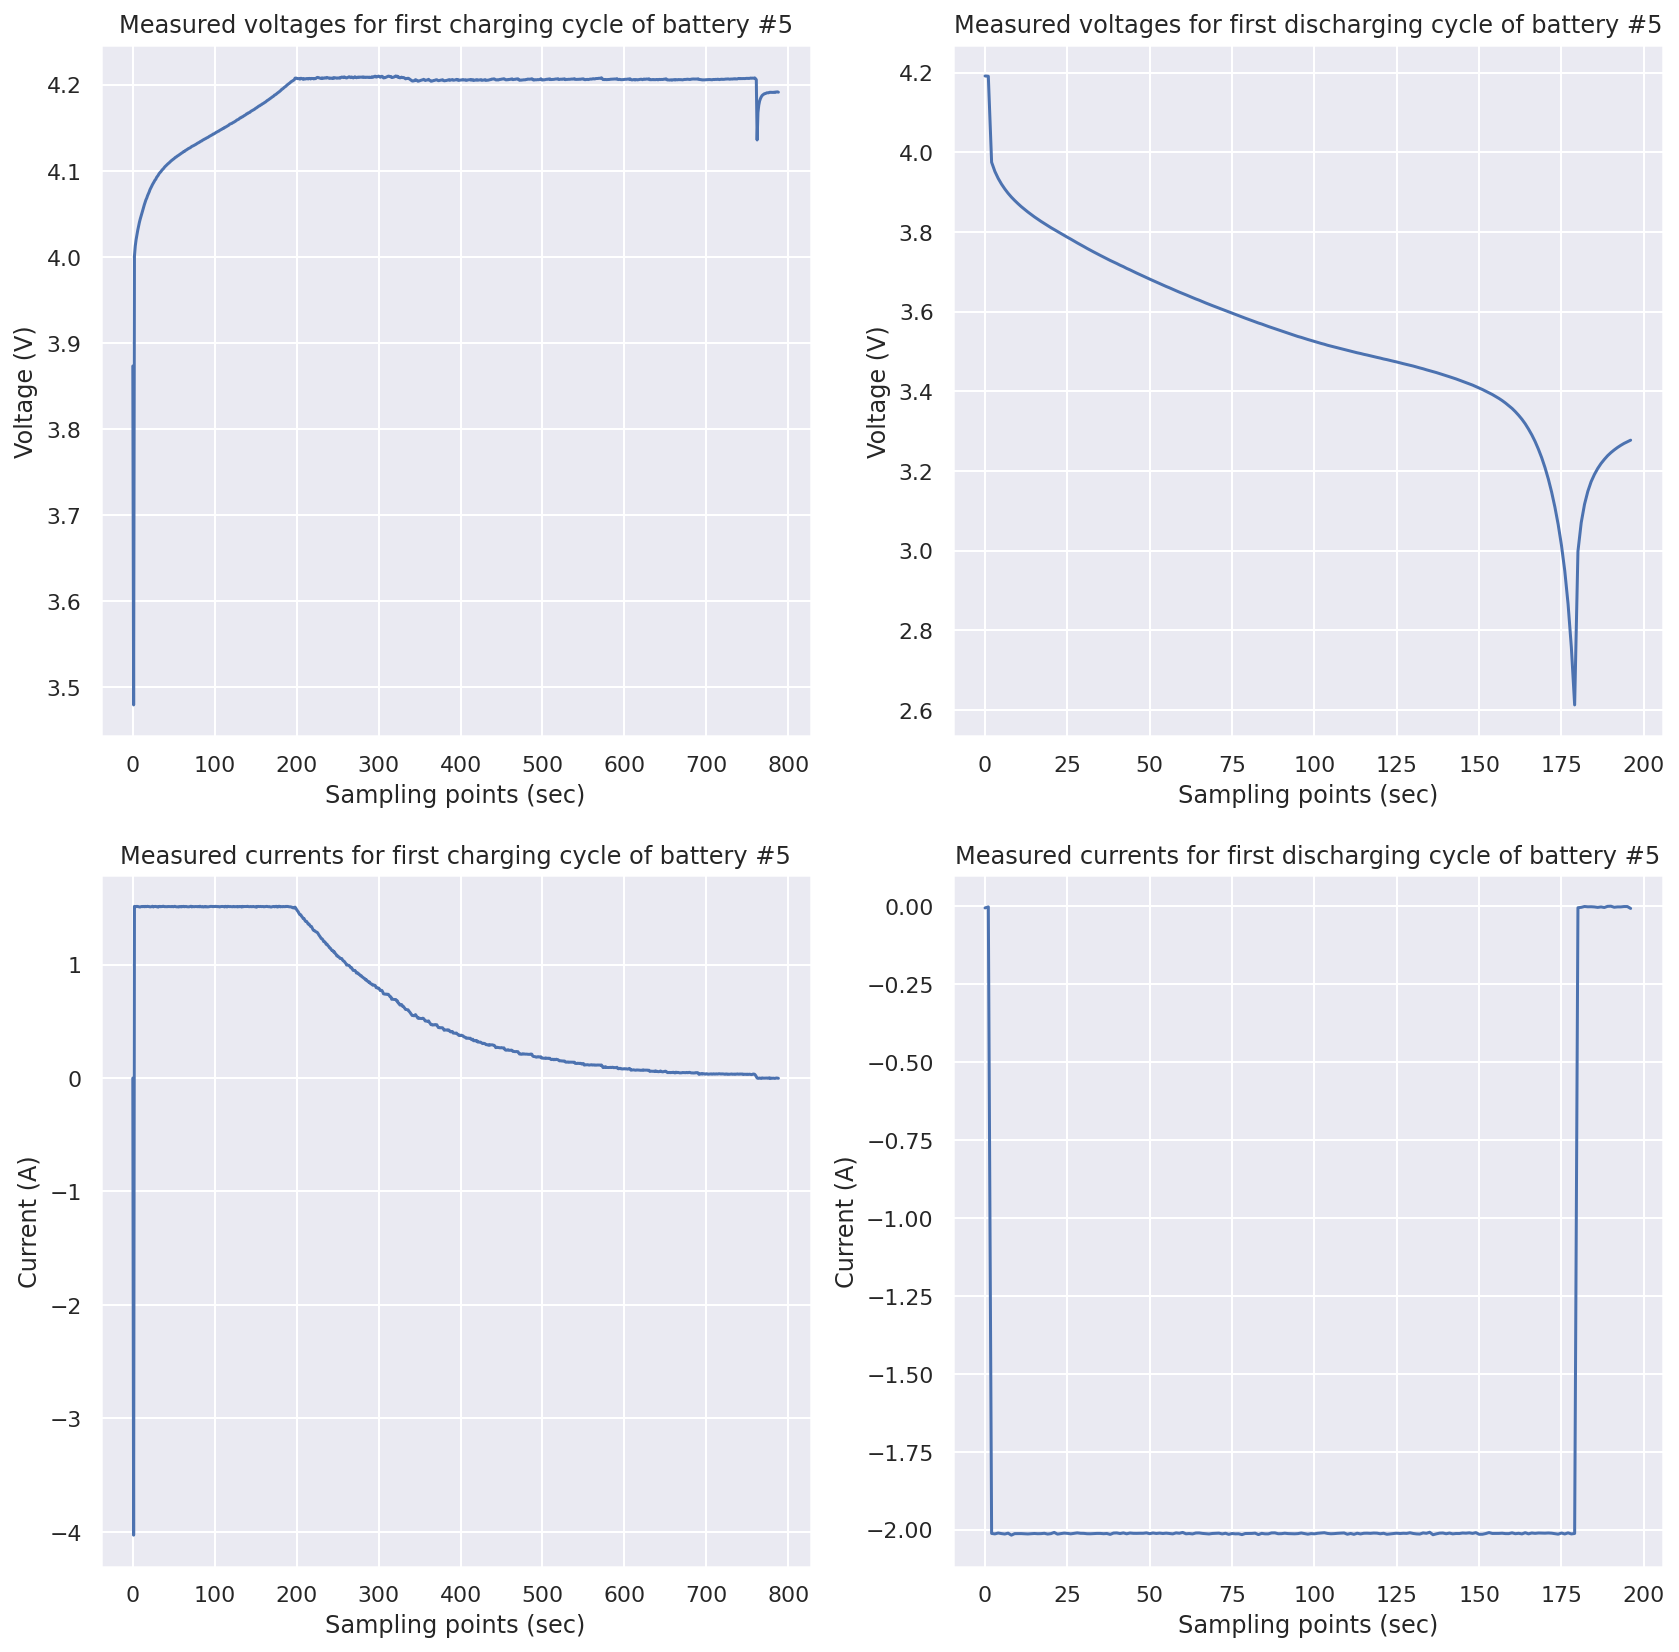

In [17]:
# Plot data for first cycle of battery

plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.plot(charging_voltages)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Voltage (V)")
plt.title(f"Measured voltages for first charging cycle of battery #{battery_number}")

# Plot discharging voltages
plt.subplot(2, 2, 2)
plt.plot(discharging_voltages)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Voltage (V)")
plt.title(
    f"Measured voltages for first discharging cycle of battery #{battery_number}"
)

# Plot charging currents
plt.subplot(2, 2, 3)
plt.plot(charging_currents)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Current (A)")
plt.title(f"Measured currents for first charging cycle of battery #{battery_number}")

# Plot discharging currents
plt.subplot(2, 2, 4)
plt.plot(discharging_currents)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Current (A)")
plt.title(
    f"Measured currents for first discharging cycle of battery #{battery_number}"
)

plt.show()

## Data export to CSV files

In [18]:
# Export data in CSV form for all batteries in the dataset

battery_numbers = [5, 6, 7, 18]

for battery_number in battery_numbers:
    # Load file data
    mat_file_name = "B00" + f"{battery_number:02d}"
    mat_data = get_file_data(mat_file_name)
    cycles = mat_data[0][0][0][0]

    discharging_data = []

    for cycle in cycles:
        # Cycle structure: type, ambient_temperature, time, data
        cycle_type = cycle[0][0]

        if cycle_type == "discharge":
            # Discharge cycle structure: Voltage_measured, Current_measured, Temperature_measured,	Current_charge, Voltage_charge, Time, Capacity
            cycle_data = cycle[3]
            voltages_measured = cycle_data[0][0][0][0]
            voltage_measured = voltages_measured[-1]
            currents_measured = cycle_data[0][0][1][0]
            current_measured = currents_measured[-1]
            temperatures_measured = cycle_data[0][0][2][0]
            temperature_measured = temperatures_measured[-1]
            currents_charge = cycle_data[0][0][3][0]
            current_charge = currents_charge[-1]
            voltages_charge = cycle_data[0][0][4][0]
            voltage_charge = voltages_charge[-1]
            capacity = cycle_data[0][0][6][0][0]
            discharging_data.append(
                [
                    voltage_measured,
                    current_measured,
                    temperature_measured,
                    current_charge,
                    voltage_charge,
                    capacity,
                ]
            )

    # Create CSV file
    export_file_name = mat_file_name + ".csv"
    with open(download_path + export_file_name, "w", newline="") as file:
        writer = csv.writer(file)
        # Write header (columns names)
        writer.writerow(
            [
                "Voltage_measured",
                "Current_measured",
                "Temperature_measured",
                "Current_charge",
                "Voltage_charge",
                "Capacity",
            ]
        )
        # Write data
        writer.writerows(discharging_data)
        print(f"File '{export_file_name}'' created successfully")

File '/tmp/B0005.mat' loaded
File 'B0005.csv'' created successfully
File '/tmp/B0006.mat' loaded
File 'B0006.csv'' created successfully
File '/tmp/B0007.mat' loaded
File 'B0007.csv'' created successfully
File '/tmp/B0018.mat' loaded
File 'B0018.csv'' created successfully


## Data analysis

In [19]:
df_battery = pd.read_csv(download_path + "B0005.csv")
print(f"Dataset shape: {df_battery.shape}")

Dataset shape: (168, 6)


In [20]:
# To be continued...

## Data preprocessing

In [21]:
def prepare_dataset(battery_number):
    ### Split a battery dataset between inputs and outputs"""

    battery_file_name = "B00" + f"{battery_number:02d}"
    df_battery = pd.read_csv(download_path + battery_file_name + ".csv")
    
    # Split dataset between input and target data
    x = df_battery.drop("Capacity", axis=1).to_numpy()
    y = df_battery["Capacity"].to_numpy()

    # Standardize input data
    x = StandardScaler().fit_transform(x)
    
    return (x, y)

In [22]:
x_train_5, y_train_5 = prepare_dataset(5)
print(f"x_train_5: {x_train_5.shape}. y_train_5: {y_train_5.shape}")

x_train_5: (168, 5). y_train_5: (168,)


## Training models

In [23]:
# To be continued...

## SOH prediction

In [24]:
# To be continued...